In [24]:
%matplotlib widget
# Load packages and settings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)
import seaborn as sns



import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf

import geopandas as gpd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)
from matplotlib import cm # Colormaps
import matplotlib.colors as colors
# cmap = plt.cm.get_cmap('Dark2',len(ageGroups))

import locale
import matplotlib.dates as mdates
# locale.setlocale(locale.LC_TIME,"Danish")
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax1.spines['top'].set_visible(False) 

import os
# import csv
import math

from datetime import date


saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))

print('Done loading packages')

saveFigures is set to: True
Done loading packages


In [25]:
# Define paths
rootdir_data = os.getcwd() +"/../DanskeData/" 

path_data = rootdir_data + "ssi_data/"
path_dash = rootdir_data + "ssi_dashboard/"
path_vacc = rootdir_data + "ssi_vacc/"

path_figs = os.getcwd() +"/../Figures/" 

path_figs = path_figs + 'CurrentStatus/'

In [26]:
latestsubdir = list(os.walk(path_data))[0][1][-1]
latestdir = path_data + latestsubdir

dfDea = pd.read_csv(latestdir+'/Deaths_over_time.csv',delimiter = ';',dtype=str)
dfDea = dfDea.iloc[:-1,:]
dfDea['Dato'] = pd.to_datetime(dfDea['Dato'])
dfDea['Antal_døde'] = pd.to_numeric(dfDea['Antal_døde'])
dfDea.tail()


,Dato,Antal_døde
723,2022-03-04,42
724,2022-03-05,44
725,2022-03-06,35
726,2022-03-07,23
727,2022-03-08,0


In [27]:
latestsubdir = list(os.walk(path_dash))[0][1][-1]
latestdir = path_dash + latestsubdir

dfReinfFile = pd.read_csv(latestdir+'/Regionalt_DB/24_reinfektioner_daglig_region.csv',encoding='latin1',delimiter = ';')
dfReinfFile['Prøvedato'] = pd.to_datetime(dfReinfFile['Prøvedato'])
# groupdf = df.groupby(['Prøvedato').sum()
# df_reinf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
# df_inf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] != '1.Reinfektion'].groupby('Prøvedato').sum()
df_reinf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller første infektion)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
df_inf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller første infektion)'] != '1.Reinfektion'].groupby('Prøvedato').sum()

In [28]:
# Load vaccinedata

latestsubdir = list(os.walk(path_vacc))[0][1][-1]
latestdir = path_vacc + latestsubdir

dfVacc = pd.read_csv(latestdir+'/Vaccine_DB/Vaccinations_Daekning_region_pr_dag.csv',encoding='latin1',delimiter = ';')
# dfVacc['Vaccinedato'] = pd.to_datetime(dfVacc['Vaccinedato'])
# dfVacc = dfVacc.groupby('Vaccinedato').sum()
dfVacc = dfVacc.rename(columns={'Vaccinedato':'Date','Kumulerede antal færdigvacc.':'Antal'})
dfVacc['Date'] = pd.to_datetime(dfVacc['Date'])
dfVacc = dfVacc.groupby('Date').sum()
dfVacc['Ratio'] = dfVacc['Antal']/dfVacc['Antal borgere']
dfVacc.tail()


,Antal,Antal borgere,Vaccinations dækning (%),Ratio
Date,,,,
2022-03-03,4758976,5879275,407.0,0.809449
2022-03-04,4759254,5879275,407.0,0.809497
2022-03-05,4759471,5879275,407.0,0.809534
2022-03-06,4759650,5879275,407.0,0.809564
2022-03-07,4759889,5879275,407.0,0.809605


In [59]:

dfRevacc = pd.read_csv(latestdir+'/Vaccine_DB/Revacc1_region_dag.csv',encoding='latin1',delimiter = ';')
dfRevacc = dfRevacc.rename(columns={'Revacc. 1 dato': 'Date','Antal revacc. 1':'Count'})
dfRevacc['Date'] = pd.to_datetime(dfRevacc['Date'])
dfRevacc = dfRevacc.groupby('Date').sum()
dfRevacc['Cumulative'] = np.cumsum(dfRevacc['Count'])
dfRevacc['Ratio'] = dfRevacc['Cumulative']/dfVacc['Antal borgere'].values[-1]
dfRevacc.tail()

,Count,Cumulative,Ratio
Date,,,
2022-03-03,1289,3596036,0.611646
2022-03-04,1203,3597239,0.611851
2022-03-05,838,3598077,0.611993
2022-03-06,879,3598956,0.612143
2022-03-07,1223,3600179,0.612351


# Make WinterWave comparison

In [47]:
# keyCaseReInf[np.isnan(keyCaseReInf)] = 0
# totCase = keyCase + keyCaseReInf

dfCase = pd.DataFrame() 
dfCase['Dato'] = df_inf.index 
dfCase['New'] = df_inf.infected.values
dfCase['Re'] = df_reinf.infected.values 
dfCase['Total'] = df_inf.infected.values + df_reinf.infected.values
dfCase
dfDea = dfDea.rename(columns={'Antal_døde': 'Deaths'})

dfFull = pd.merge(dfCase,dfDea,how='outer')
dfFull['Deaths'] = dfFull['Deaths'].fillna(0)
dfFull = dfFull.iloc[:-1]

curDates = dfFull.Dato.values 
curCases = dfFull.Total.values  
curDeaths = dfFull.Deaths.values  

In [48]:
wave1Start = np.datetime64('2020-10-01') 
wave1End = np.datetime64('2021-03-01') 
caseWave1 = curCases[(curDates >= wave1Start- np.timedelta64(4,'D')) & (curDates <= wave1End+ np.timedelta64(4,'D'))]
deathWave1 = curDeaths[(curDates >= wave1Start- np.timedelta64(4,'D')) & (curDates <= wave1End+ np.timedelta64(4,'D'))]
daysWave1 = curDates[(curDates >= wave1Start- np.timedelta64(4,'D')) & (curDates <= wave1End+ np.timedelta64(4,'D'))]

wave2Start = np.datetime64('2021-11-01') 
wave2End = np.datetime64('2022-04-01')
caseWave2 = curCases[(curDates >= wave2Start- np.timedelta64(4,'D')) & (curDates <= wave2End + np.timedelta64(4,'D'))]
deathWave2 = curDeaths[(curDates >= wave2Start- np.timedelta64(4,'D')) & (curDates <= wave2End + np.timedelta64(4,'D'))]
daysWave2 = curDates[(curDates >= wave2Start- np.timedelta64(4,'D')) & (curDates <= wave2End + np.timedelta64(4,'D'))]

In [49]:

wave1TopIndex = np.argmax(pf.rnMean(caseWave1))

wave1TopDate = pf.rnTime(daysWave1)[wave1TopIndex]
wave1TopCase = pf.rnMean(caseWave1)[wave1TopIndex]

wave2TopIndex = np.argmax(pf.rnMean(caseWave2))

wave2TopDate = pf.rnTime(daysWave2)[wave2TopIndex]
wave2TopCase = pf.rnMean(caseWave2)[wave2TopIndex]

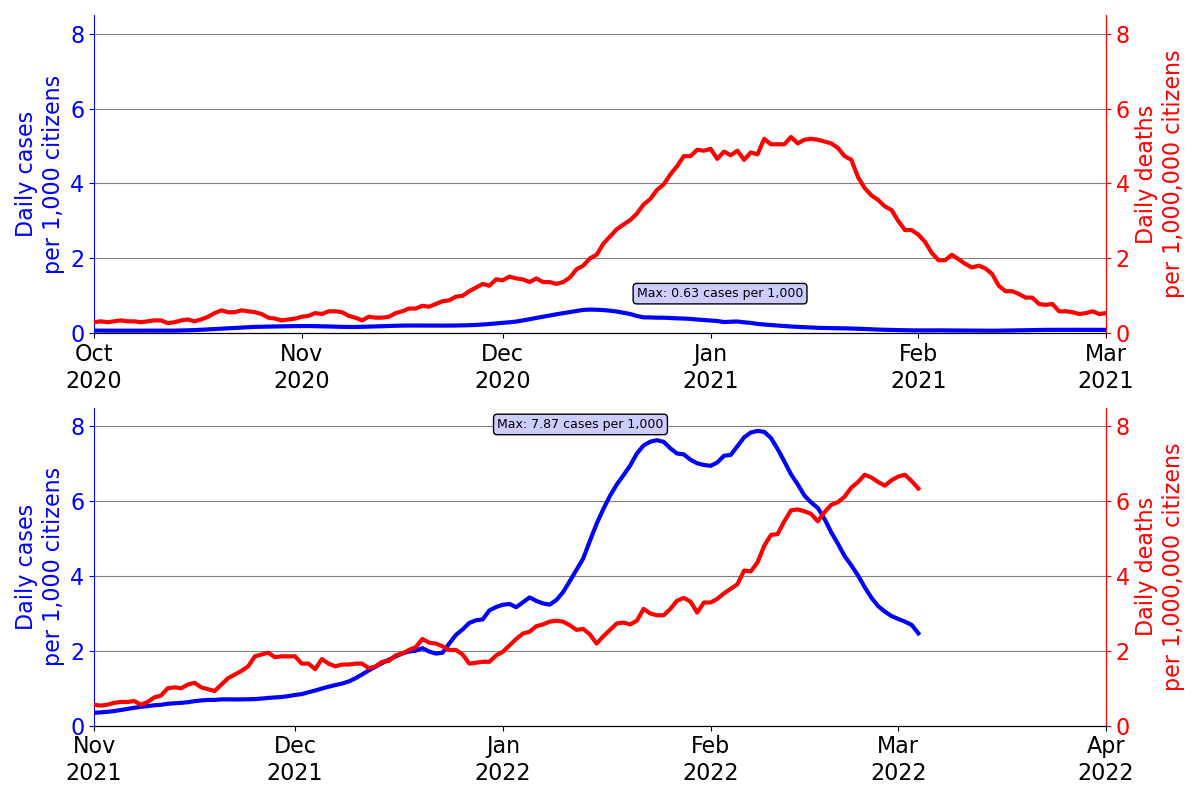

In [50]:
fig,(ax1,ax2) = plt.subplots(2,1) 

DKpop = 5860590 # According to data in reinfection file

ax1_2 = ax1.twinx()
ax2_2 = ax2.twinx() 

# ax1.plot(keyDates,1000*keyCase/DKpop)
# ax1_2.plot(keyDates,1000*keyDeath/DKpop,'r')

# ax1.plot(daysWave1,1000*caseWave1/DKpop)
# ax1_2.plot(daysWave1,1000000*deathWave1/DKpop,'r')
ax1.plot(pf.rnTime(daysWave1),pf.rnMean(1000*caseWave1/DKpop),'b')
ax1_2.plot(pf.rnTime(daysWave1),pf.rnMean(1000000*deathWave1/DKpop),'r')

# ax2.plot(daysWave2,1000*caseWave2/DKpop)
# ax2_2.plot(daysWave2,1000000*deathWave2/DKpop,'r')
ax2.plot(pf.rnTime(daysWave2),pf.rnMean(1000*caseWave2/DKpop),'b')
ax2_2.plot(pf.rnTime(daysWave2),pf.rnMean(1000000*deathWave2/DKpop),'r')




ax1.set_ylim(bottom=0)
ax1_2.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax2_2.set_ylim(bottom=0)

ax1_2.set_ylim(top=8.5)
ax2_2.set_ylim(top=8.5)

ax1.set_ylim(top=8.5)
ax2.set_ylim(top=8.5)

ax1.set_xlim([wave1Start,wave1End])
ax1_2.set_xlim([wave1Start,wave1End])

ax2.set_xlim([wave2Start,wave2End])
ax2_2.set_xlim([wave2Start,wave2End])

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

ax1.set_ylabel('Daily cases\nper 1,000 citizens')
ax2.set_ylabel('Daily cases\nper 1,000 citizens')
ax1_2.set_ylabel('Daily deaths\nper 1,000,000 citizens')
ax2_2.set_ylabel('Daily deaths\nper 1,000,000 citizens')
# ax1.set_ylabel('Daily cases\nper 1,000 citizens\n[7 day mean]')
# ax2.set_ylabel('Daily cases\nper 1,000 citizens\n[7 day mean]')
# ax1_2.set_ylabel('Daily deaths\nper 1,000,000 citizens\n[7 day mean]')
# ax2_2.set_ylabel('Daily deaths\nper 1,000,000 citizens\n[7 day mean]')
# ax2.set_ylabel('Cases per 1,000 citizens')
# ax2_2.set_ylabel('Deaths per 1,000,000 citizens')



# ax1.spines['right'].set_visible=('b')

ax1.yaxis.label.set_color('b')
ax2.yaxis.label.set_color('b')

ax1.spines['left'].set_edgecolor('b')
ax2.spines['left'].set_edgecolor('b')

ax1_2.yaxis.label.set_color('r')
ax2_2.yaxis.label.set_color('r')

ax1_2.spines['right'].set_edgecolor('r')
ax2_2.spines['right'].set_edgecolor('r')

ax1_2.spines['left'].set_visible(False)
ax2_2.spines['left'].set_visible(False)


ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1_2.spines['top'].set_visible(False)
ax2_2.spines['top'].set_visible(False)

ax1.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='b')
ax1_2.tick_params(axis='y', colors='r')
ax2_2.tick_params(axis='y', colors='r')

ax1.grid(axis='y',color='gray')
ax2.grid(axis='y',color='gray')



fig.tight_layout()

if saveFigures:
        fig.savefig(path_figs + 'WinterWavesCaseAndDeaths')



wave1Max = 1000*wave1TopCase/DKpop
ax1.text(wave1TopDate+np.timedelta64(7,'D'),wave1Max*1.4,f'Max: {wave1Max:0.2f} cases per 1,000',
        size=9,
        ha="left", va="bottom",
        bbox=dict(boxstyle="round",
                   ec=(0., 0,0),
                   fc=(0.8, 0.8, 1),
                   ))

if saveFigures:
        fig.savefig(path_figs + 'WinterWavesCaseAndDeaths_WithLabelsOnlyOne')

wave2Max = 1000*wave2TopCase/DKpop
ax2.text(wave2TopDate-np.timedelta64(14,'D'),wave2Max,f'Max: {wave2Max:0.2f} cases per 1,000',
        size=9,
        ha="right", va="bottom",
        bbox=dict(boxstyle="round",
                   ec=(0., 0,0),
                   fc=(0.8, 0.8, 1),
                   ))

                   
if saveFigures:
        fig.savefig(path_figs + 'WinterWavesCaseAndDeaths_WithLabels')

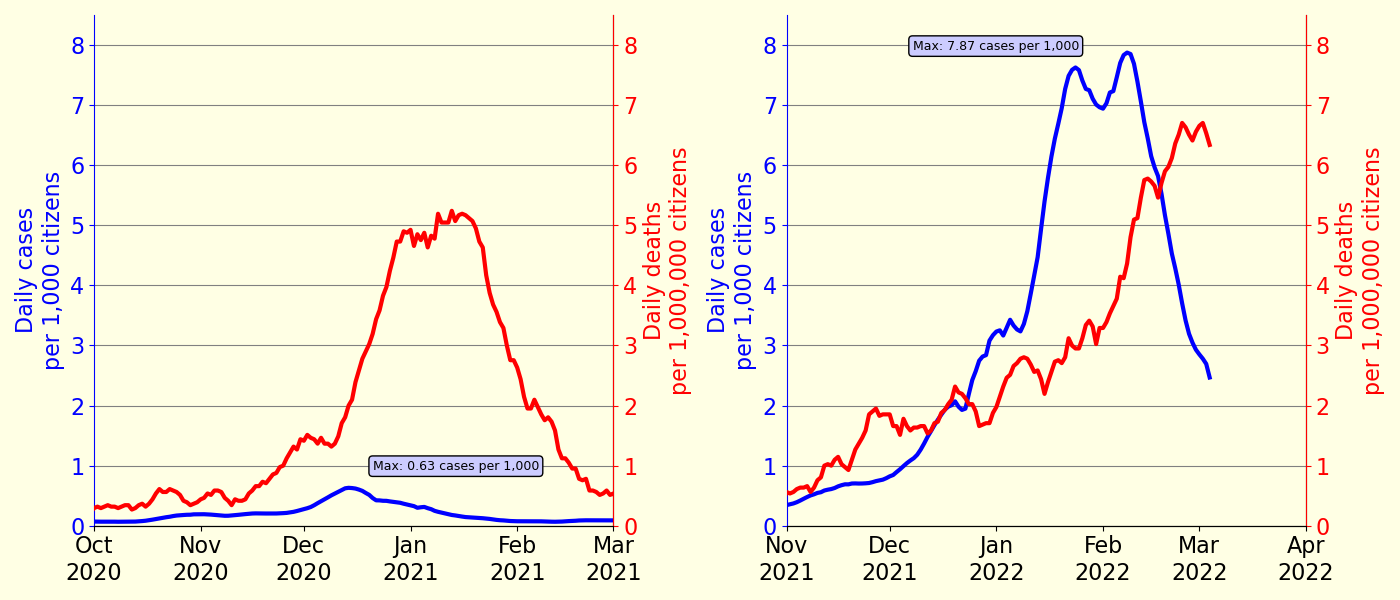

In [129]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6)) 

bgColor = 'xkcd:off white'
fig.patch.set_facecolor(bgColor)
ax1.set_facecolor(bgColor)
ax2.set_facecolor(bgColor)

DKpop = 5860590 # According to data in reinfection file

ax1_2 = ax1.twinx()
ax2_2 = ax2.twinx() 

# ax1.plot(keyDates,1000*keyCase/DKpop)
# ax1_2.plot(keyDates,1000*keyDeath/DKpop,'r')

# ax1.plot(daysWave1,1000*caseWave1/DKpop)
# ax1_2.plot(daysWave1,1000000*deathWave1/DKpop,'r')
ax1.plot(pf.rnTime(daysWave1),pf.rnMean(1000*caseWave1/DKpop),'b')
ax1_2.plot(pf.rnTime(daysWave1),pf.rnMean(1000000*deathWave1/DKpop),'r')

# ax2.plot(daysWave2,1000*caseWave2/DKpop)
# ax2_2.plot(daysWave2,1000000*deathWave2/DKpop,'r')
ax2.plot(pf.rnTime(daysWave2),pf.rnMean(1000*caseWave2/DKpop),'b')
ax2_2.plot(pf.rnTime(daysWave2),pf.rnMean(1000000*deathWave2/DKpop),'r')




ax1.set_ylim(bottom=0)
ax1_2.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax2_2.set_ylim(bottom=0)

ax1_2.set_ylim(top=8.5)
ax2_2.set_ylim(top=8.5)

ax1.set_ylim(top=8.5)
ax2.set_ylim(top=8.5)

ax1.set_xlim([wave1Start,wave1End])
ax1_2.set_xlim([wave1Start,wave1End])

ax2.set_xlim([wave2Start,wave2End])
ax2_2.set_xlim([wave2Start,wave2End])

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

ax1.set_ylabel('Daily cases\nper 1,000 citizens')
ax2.set_ylabel('Daily cases\nper 1,000 citizens')
ax1_2.set_ylabel('Daily deaths\nper 1,000,000 citizens')
ax2_2.set_ylabel('Daily deaths\nper 1,000,000 citizens')
# ax1.set_ylabel('Daily cases\nper 1,000 citizens\n[7 day mean]')
# ax2.set_ylabel('Daily cases\nper 1,000 citizens\n[7 day mean]')
# ax1_2.set_ylabel('Daily deaths\nper 1,000,000 citizens\n[7 day mean]')
# ax2_2.set_ylabel('Daily deaths\nper 1,000,000 citizens\n[7 day mean]')
# ax2.set_ylabel('Cases per 1,000 citizens')
# ax2_2.set_ylabel('Deaths per 1,000,000 citizens')



# ax1.spines['right'].set_visible=('b')

ax1.yaxis.label.set_color('b')
ax2.yaxis.label.set_color('b')

ax1.spines['left'].set_edgecolor('b')
ax2.spines['left'].set_edgecolor('b')

ax1_2.yaxis.label.set_color('r')
ax2_2.yaxis.label.set_color('r')

ax1_2.spines['right'].set_edgecolor('r')
ax2_2.spines['right'].set_edgecolor('r')

ax1_2.spines['left'].set_visible(False)
ax2_2.spines['left'].set_visible(False)


ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1_2.spines['top'].set_visible(False)
ax2_2.spines['top'].set_visible(False)

ax1.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='b')
ax1_2.tick_params(axis='y', colors='r')
ax2_2.tick_params(axis='y', colors='r')

ax1.grid(axis='y',color='gray')
ax2.grid(axis='y',color='gray')



fig.tight_layout()

if saveFigures:
        fig.savefig(path_figs + 'WinterWavesCaseAndDeathsUpdate')



wave1Max = 1000*wave1TopCase/DKpop
ax1.text(wave1TopDate+np.timedelta64(7,'D'),wave1Max*1.4,f'Max: {wave1Max:0.2f} cases per 1,000',
        size=9,
        ha="left", va="bottom",
        bbox=dict(boxstyle="round",
                   ec=(0., 0,0),
                   fc=(0.8, 0.8, 1),
                   ))

if saveFigures:
        fig.savefig(path_figs + 'WinterWavesCaseAndDeathsUpdate_WithLabelsOnlyOne')

wave2Max = 1000*wave2TopCase/DKpop
ax2.text(wave2TopDate-np.timedelta64(14,'D'),wave2Max,f'Max: {wave2Max:0.2f} cases per 1,000',
        size=9,
        ha="right", va="bottom",
        bbox=dict(boxstyle="round",
                   ec=(0., 0,0),
                   fc=(0.8, 0.8, 1),
                   ))

                   
if saveFigures:
        fig.savefig(path_figs + 'WinterWavesCaseAndDeathsUpdate_WithLabels')

# Naive case-fatality rate

(0.0, 41.25)

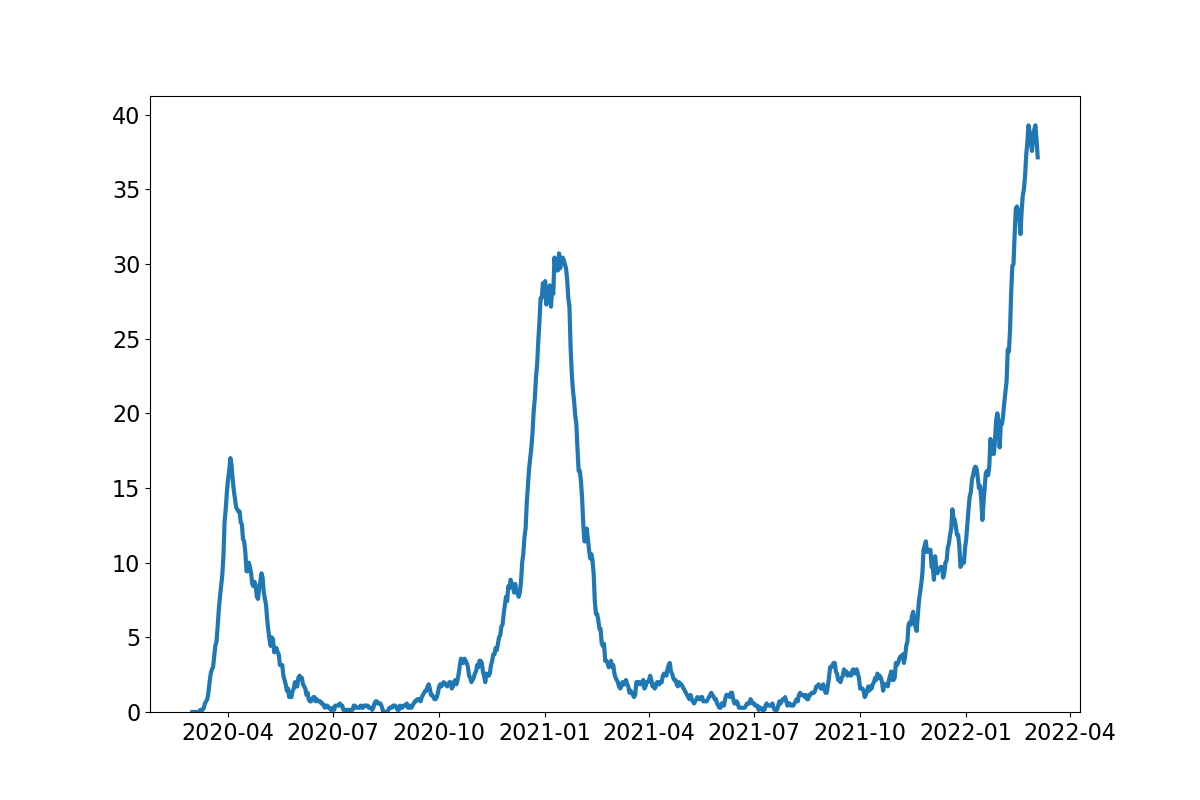

In [51]:
# fig,allAxes = plt.subplots(3,1,sharex=True)
fig,ax1 = plt.subplots()


ax1.plot(pf.rnTime(curDates),pf.rnMean(curDeaths))


# rnDates = pf.rnTime(curDates)
# rnCases = pf.rnMean(curCases)
# rnDeaths = pf.rnMean(curDeaths)
# cfr = rnDeaths[21:]/rnCases[:-21]
# ax3.plot(rnDates[21:],cfr)

# ax3.set_yscale('log')

ax1.set_ylim(bottom=0)

# ax3.set_ylim([0,0.1])

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_12596\1425150663.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim([0,0.1])


(0.00017975862199904054, 0.1)

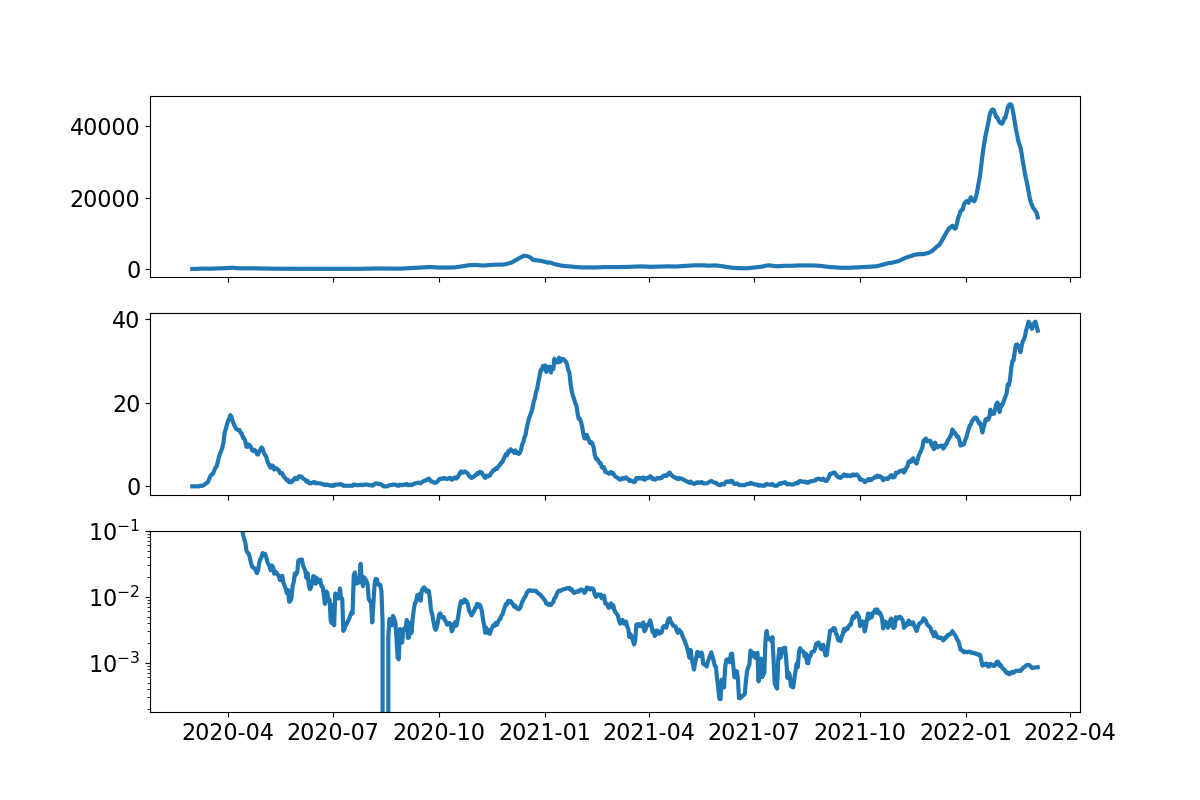

In [52]:
fig,allAxes = plt.subplots(3,1,sharex=True)

ax1 = allAxes.flatten()[0]
ax2 = allAxes.flatten()[1]
ax3 = allAxes.flatten()[2]

ax1.plot(pf.rnTime(curDates),pf.rnMean(curCases))

ax2.plot(pf.rnTime(curDates),pf.rnMean(curDeaths))


rnDates = pf.rnTime(curDates)
rnCases = pf.rnMean(curCases)
rnDeaths = pf.rnMean(curDeaths)
cfr = rnDeaths[21:]/rnCases[:-21]
ax3.plot(rnDates[21:],cfr)

ax3.set_yscale('log')

ax3.set_ylim([0,0.1])

C:\Users\rakrpe\.conda\envs\main\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


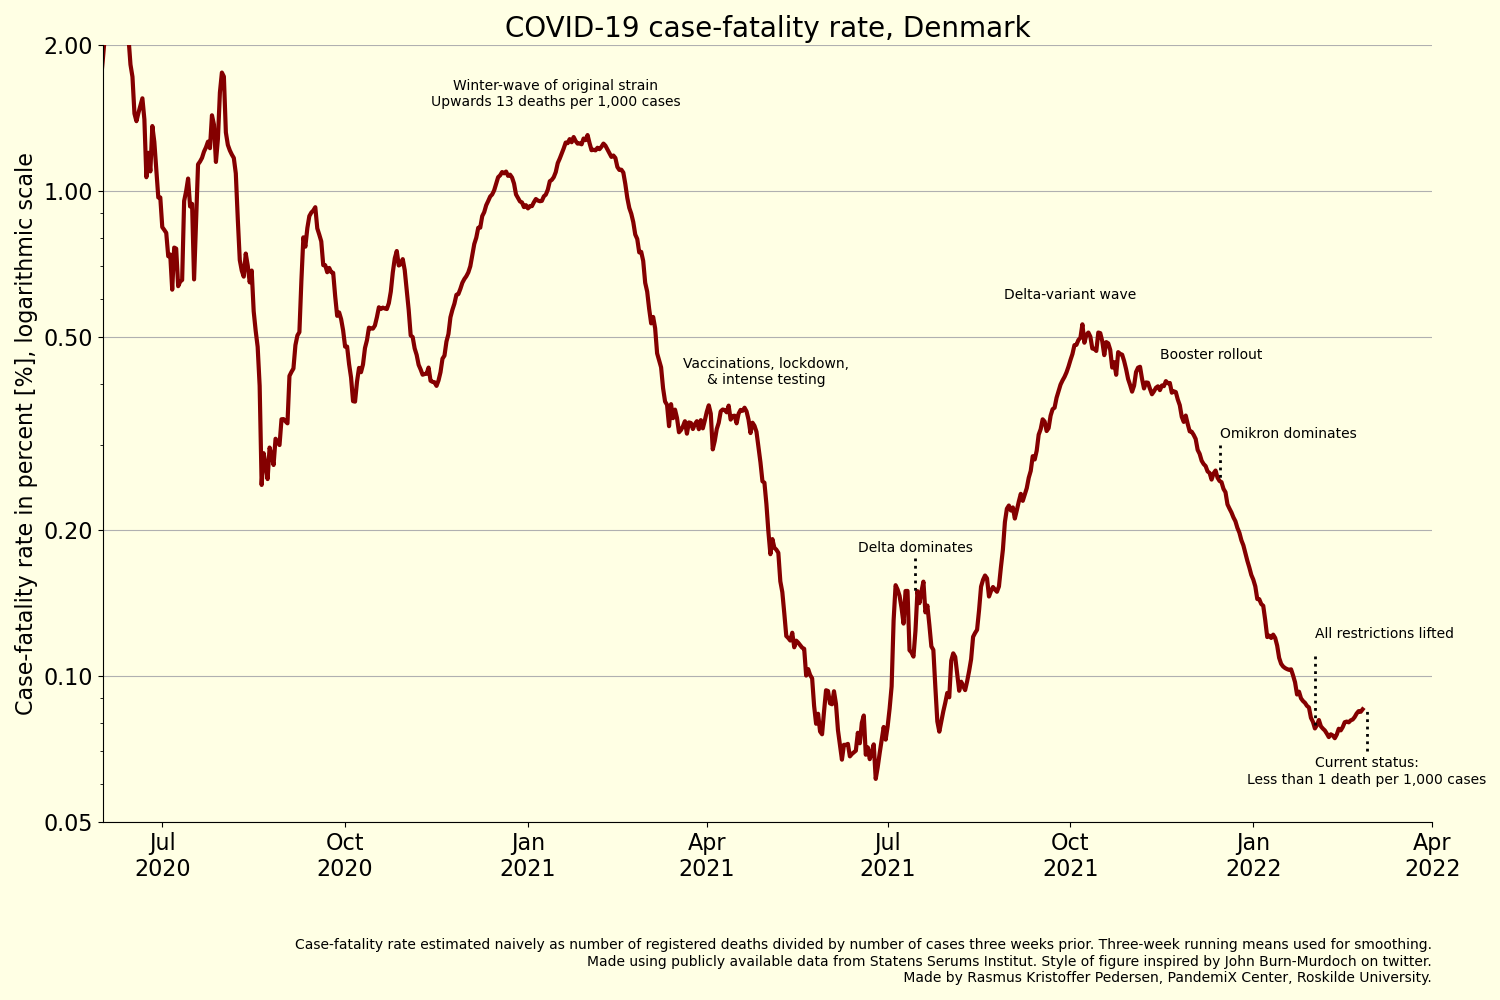

In [124]:

fig,ax1 = plt.subplots(figsize=(15,10)) 

bgColor = 'xkcd:off white'
fig.patch.set_facecolor(bgColor)
ax1.set_facecolor(bgColor)

rnDates = pf.rnTime(curDates,21)
rnCases = pf.rnMean(curCases,21)
rnDeaths = pf.rnMean(curDeaths,21)
cfr = rnDeaths[21:]/rnCases[:-21]

ax1.plot(rnDates[21:],100*cfr,'xkcd:dark red')

ax1.set_yscale('log')

ax1.set_ylim(top=2)
ax1.set_ylim(bottom=0.05)

    
def fmt(x, pos):
    return f'{x:1.2f}'
import matplotlib.ticker as ticker 
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(fmt))
# ax1.yaxis.set_minor_formatter(ticker.FuncFormatter(fmt))
ax1.tick_params(which='minor', labelsize=8) 


ax1.set_yticks([0.05,0.1,0.2,0.5,1,2])
ax1.grid(axis='y')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax1.set_title('COVID-19 case-fatality rate, Denmark')
ax1.set_ylabel('Case-fatality rate in percent [%], logarithmic scale')

smalltxt = 'Case-fatality rate estimated naively as number of registered deaths divided by number of cases three weeks prior.\nThree-week running means used for smoothing. PandemiX Center, Roskilde University. Based on publicly available data from Statens Serums Institut.'
smalltxt = 'Case-fatality rate estimated naively as number of registered deaths divided by number of cases three weeks prior. Three-week running means used for smoothing.\nMade using publicly available data from Statens Serums Institut. Style of figure inspired by John Burn-Murdoch on twitter.\n Made by Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde University.'
# smalltxt = 'Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet.\nData fra SSI overvågningsdata, dashboard-fil. Filnavn: Regionalt_DB/18_fnkt_alder_uge_testede_positive_nyindlagte.csv'
ax1.text(1,-0.15,smalltxt,
     horizontalalignment='right',
     verticalalignment='top',
     transform = ax1.transAxes,
     fontsize=10)
     
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

xTicks = np.arange(np.datetime64('2020-04'),np.datetime64('2022-09'),np.timedelta64(3,'M'))
ax1.set_xticks(xTicks)


ax1.set_xlim(left=np.datetime64('2020-06'))
ax1.set_xlim(right=np.datetime64('today'))
ax1.set_xlim(right=np.datetime64('2022-04'))

fig.tight_layout()

if saveFigures:
    fig.savefig(path_figs+'CaseFatality_NoLabels')

def getValOnDay(date):
    curIndex = rnDates[21:] == date 
    return 100*cfr[curIndex]

# ax1.text(np.datetime64('2020-06-15'),0.22,'(Uncertain period due to low testing)',
#         size=10
#         )
# ax1.text(np.datetime64('2021-01-15'),1.5,'Upwards 1.3% of cases in\nwinter-wave of original strain',
#         size=10,ha='center'
#         )
ax1.text(np.datetime64('2021-01-15'),1.5,'Winter-wave of original strain\nUpwards 13 deaths per 1,000 cases',
        size=10,ha='center'
        )
ax1.text(np.datetime64('2021-05-01'),0.4,'Vaccinations, lockdown,\n& intense testing',
        size=10,ha='center'
        )

thisDate = np.datetime64('2021-07-15')
ax1.text(thisDate,.18,'Delta dominates',
        size=10,ha='center'
        )
thisY = getValOnDay(thisDate+np.timedelta64(3,'D'))
ax1.plot([thisDate,thisDate],[0.175,thisY],'k:',linewidth=2)

ax1.text(np.datetime64('2021-10-01'),.6,'Delta-variant wave',
        size=10,ha='center'
        )
ax1.text(np.datetime64('2021-11-15'),.45,'Booster rollout',
        size=10,ha='left'
        )

thisDate = np.datetime64('2021-12-15')
ax1.text(thisDate,.31,'Omikron dominates',
        size=10,ha='left'
        )
thisY = getValOnDay(thisDate)
ax1.plot([thisDate,thisDate],[0.3,thisY],'k:',linewidth=2)

thisDate = np.datetime64('2022-02-01')
ax1.text(thisDate,.12,'All restrictions lifted',
        size=10,ha='left'
        )
thisY = getValOnDay(thisDate)
ax1.plot([thisDate,thisDate],[0.11,thisY],'k:',linewidth=2)

thisDate = np.datetime64('2022-02-27')
ax1.text(thisDate,0.06,'Current status:\nLess than 1 death per 1,000 cases',
        size=10,ha='center'
        )
# thisY = getValOnDay(thisDate)
thisY = 100*cfr[-1]
ax1.plot([thisDate,thisDate],[0.07,thisY],'k:',linewidth=2)

fig.tight_layout()


if saveFigures:
    fig.savefig(path_figs+'CaseFatality')

# Vaccinations

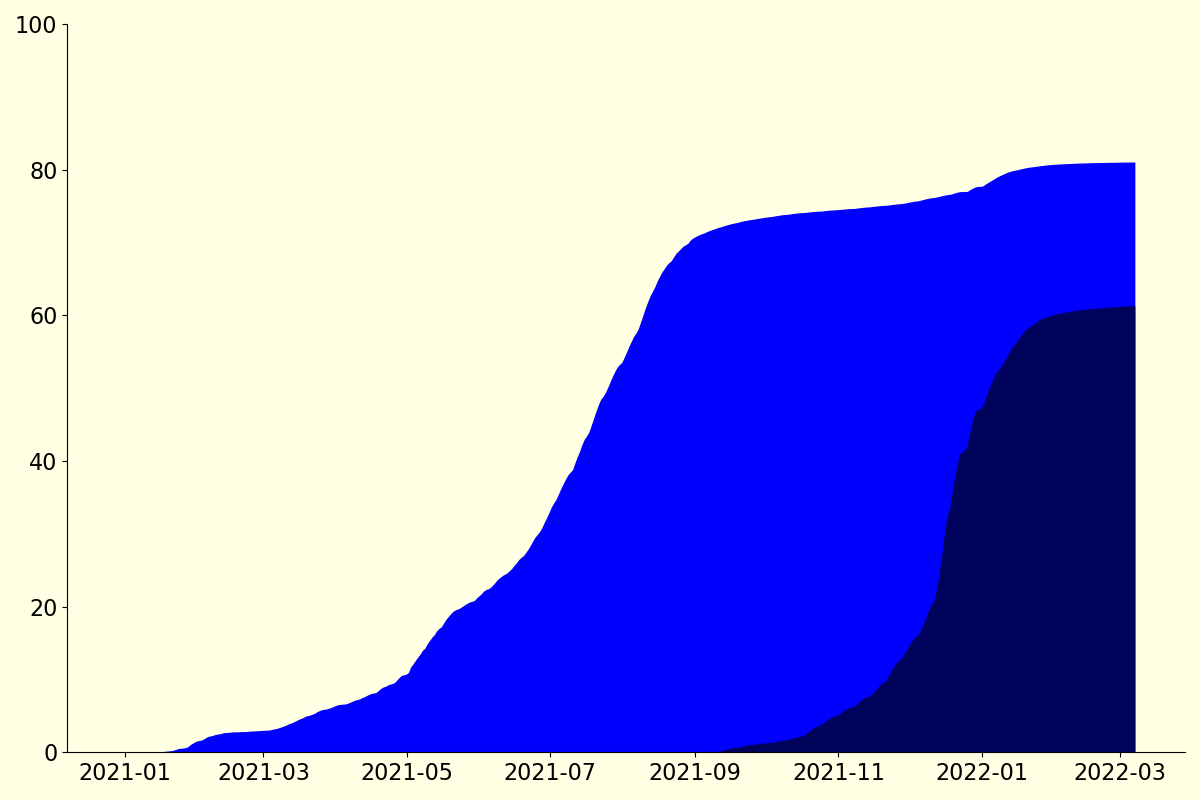

In [68]:
fig,ax1 = plt.subplots()

bgColor = 'xkcd:off white'
fig.patch.set_facecolor(bgColor)
ax1.set_facecolor(bgColor)

# ax1.plot(dfVacc.index,dfVacc.Ratio)
# ax1.plot(dfRevacc.index,dfRevacc.Ratio)
ax1.fill_between(dfVacc.index,100*dfVacc.Ratio,color='b')
ax1.fill_between(dfRevacc.index,100*dfRevacc.Ratio,color='xkcd:dark blue')
ax1.set_ylim([0,100])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

fig.tight_layout()

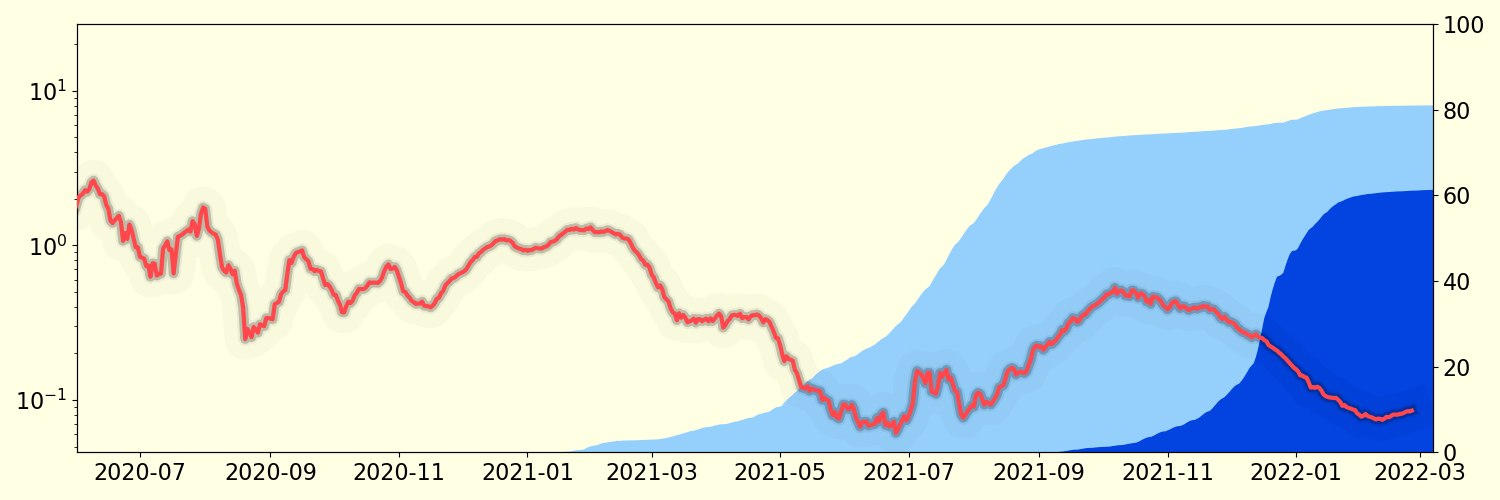

In [94]:

fig,ax1 = plt.subplots(figsize=(15,5)) 

bgColor = 'xkcd:off white'
fig.patch.set_facecolor(bgColor)
ax1.set_facecolor(bgColor)

ax1_3 = ax1.twinx()
ax1_3.fill_between(dfVacc.index,100*dfVacc.Ratio,color='xkcd:light blue',zorder=-2)
ax1_3.fill_between(dfRevacc.index,100*dfRevacc.Ratio,color='xkcd:blue',zorder=-1)
ax1_3.set_ylim([0,100])

ax1.set_zorder(1) 
ax1.patch.set_visible(False)


rnDates = pf.rnTime(curDates,21)
rnCases = pf.rnMean(curCases,21)
rnDeaths = pf.rnMean(curDeaths,21)
cfr = rnDeaths[21:]/rnCases[:-21]
 
ax1.plot(rnDates[21:],100*cfr,'k',alpha=0.025,linewidth=30,zorder=4)
ax1.plot(rnDates[21:],100*cfr,'k',alpha=0.05,linewidth=10,zorder=4)
ax1.plot(rnDates[21:],100*cfr,'k',alpha=0.2,linewidth=7,zorder=2)
ax1.plot(rnDates[21:],100*cfr,'xkcd:light red',zorder=5)

ax1.set_yscale('log')


ax1.set_xlim(left=np.datetime64('2020-06'))
ax1.set_xlim(right=np.datetime64('today'))
ax1.set_xlim(right=dfRevacc.index.values[-1])

ax1.set_zorder(1) 
ax1.patch.set_visible(False)

fig.tight_layout()


C:\Users\rakrpe\.conda\envs\main\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


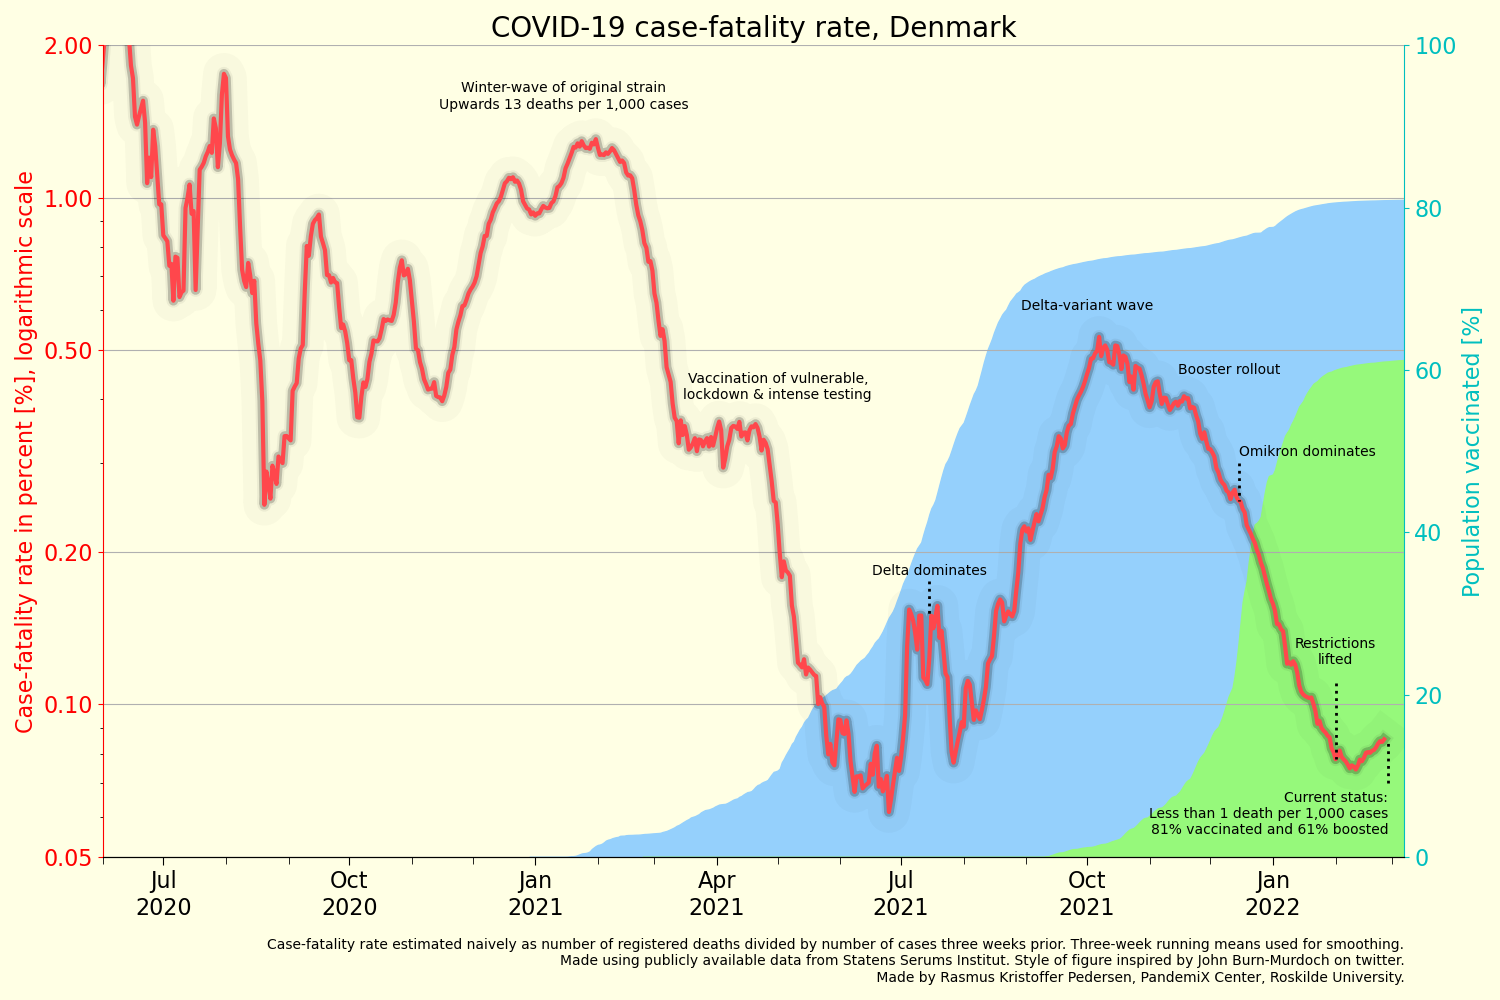

In [130]:

fig,ax1 = plt.subplots(figsize=(15,10)) 

bgColor = 'xkcd:off white'
fig.patch.set_facecolor(bgColor)
ax1.set_facecolor(bgColor)

ax1_2 = ax1.twinx()
ax1_2.fill_between(dfVacc.index,100*dfVacc.Ratio,color='xkcd:light blue',zorder=-2)
ax1_2.fill_between(dfRevacc.index,100*dfRevacc.Ratio,color='xkcd:light green',zorder=-1)
ax1_2.set_ylim([0,100])

ax1.set_zorder(1) 
ax1.patch.set_visible(False)


rnDates = pf.rnTime(curDates,21)
rnCases = pf.rnMean(curCases,21)
rnDeaths = pf.rnMean(curDeaths,21)
cfr = rnDeaths[21:]/rnCases[:-21]

ax1.plot(rnDates[21:],100*cfr,'k',alpha=0.025,linewidth=30)
ax1.plot(rnDates[21:],100*cfr,'k',alpha=0.05,linewidth=10)
ax1.plot(rnDates[21:],100*cfr,'k',alpha=0.2,linewidth=7)
ax1.plot(rnDates[21:],100*cfr,'xkcd:light red')


ax1.set_yscale('log')

ax1.set_ylim(top=2)
ax1.set_ylim(bottom=0.05)

    
def fmt(x, pos):
    return f'{x:1.2f}'
import matplotlib.ticker as ticker 
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(fmt))
# ax1.yaxis.set_minor_formatter(ticker.FuncFormatter(fmt))
ax1.tick_params(which='minor', labelsize=8) 

import matplotlib.dates as mdates
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.tick_params(axis='x',which='major',length=6)
ax1.tick_params(axis='x',which='minor',length=5)

ax1.set_yticks([0.05,0.1,0.2,0.5,1,2])
ax1.grid(axis='y')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax1.set_title('COVID-19 case-fatality rate, Denmark')
ax1.set_ylabel('Case-fatality rate in percent [%], logarithmic scale')

smalltxt = 'Case-fatality rate estimated naively as number of registered deaths divided by number of cases three weeks prior.\nThree-week running means used for smoothing. PandemiX Center, Roskilde University. Based on publicly available data from Statens Serums Institut.'
smalltxt = 'Case-fatality rate estimated naively as number of registered deaths divided by number of cases three weeks prior. Three-week running means used for smoothing.\nMade using publicly available data from Statens Serums Institut. Style of figure inspired by John Burn-Murdoch on twitter.\n Made by Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde University.'
# smalltxt = 'Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet.\nData fra SSI overvågningsdata, dashboard-fil. Filnavn: Regionalt_DB/18_fnkt_alder_uge_testede_positive_nyindlagte.csv'
ax1.text(1,-0.1,smalltxt,
     horizontalalignment='right',
     verticalalignment='top',
     transform = ax1.transAxes,
     fontsize=10)
     
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

xTicks = np.arange(np.datetime64('2020-04'),np.datetime64('2022-09'),np.timedelta64(3,'M'))
ax1.set_xticks(xTicks)


ax1.set_xlim(left=np.datetime64('2020-06'))
ax1.set_xlim(right=np.datetime64('today'))
ax1.set_xlim(right=np.datetime64('2022-04'))

fig.tight_layout()

if saveFigures:
    fig.savefig(path_figs+'CaseFatalityWithVaccine_NoLabels')

def getValOnDay(date):
    curIndex = rnDates[21:] == date 
    return 100*cfr[curIndex]

# ax1.text(np.datetime64('2020-06-15'),0.22,'(Uncertain period due to low testing)',
#         size=10
#         )
# ax1.text(np.datetime64('2021-01-15'),1.5,'Upwards 1.3% of cases in\nwinter-wave of original strain',
#         size=10,ha='center'
#         )
ax1.text(np.datetime64('2021-01-15'),1.5,'Winter-wave of original strain\nUpwards 13 deaths per 1,000 cases',
        size=10,ha='center'
        )
# ax1.text(np.datetime64('2021-05-01'),0.4,'Vaccinations, lockdown,\n& intense testing',
ax1.text(np.datetime64('2021-05-01'),0.4,'Vaccination of vulnerable,\nlockdown & intense testing',
        size=10,ha='center'
        )

thisDate = np.datetime64('2021-07-15')
ax1.text(thisDate,.18,'Delta dominates',
        size=10,ha='center'
        )
thisY = getValOnDay(thisDate+np.timedelta64(3,'D'))
ax1.plot([thisDate,thisDate],[0.175,thisY],'k:',linewidth=2)

ax1.text(np.datetime64('2021-10-01'),.6,'Delta-variant wave',
        size=10,ha='center'
        )
ax1.text(np.datetime64('2021-11-15'),.45,'Booster rollout',
        size=10,ha='left'
        )

thisDate = np.datetime64('2021-12-15')
ax1.text(thisDate,.31,'Omikron dominates',
        size=10,ha='left'
        )
thisY = getValOnDay(thisDate)
ax1.plot([thisDate,thisDate],[0.3,thisY],'k:',linewidth=2)

thisDate = np.datetime64('2022-02-01')
ax1.text(thisDate,.12,'Restrictions\nlifted',
        size=10,ha='center'
        )
thisY = getValOnDay(thisDate)
ax1.plot([thisDate,thisDate],[0.11,thisY],'k:',linewidth=2)

thisDate = np.datetime64('2022-02-27')
statusStr = 'Current status:\nLess than 1 death per 1,000 cases'
statusStr = statusStr + f'\n{100*dfVacc.iloc[-1].Ratio:2.0f}% vaccinated'
statusStr = statusStr + f' and {100*dfRevacc.iloc[-1].Ratio:2.0f}% boosted'
ax1.text(thisDate,0.0675,statusStr,
        size=10,ha='right',va='top'
        )
# thisY = getValOnDay(thisDate)
thisY = 100*cfr[-1]
ax1.plot([thisDate,thisDate],[0.07,thisY],'k:',linewidth=2)

ax1.set_xlim(right=dfRevacc.index.values[-1])

ax1_2.set_ylabel('Population vaccinated [%]')



ax1.yaxis.label.set_color('r')
ax1.spines['left'].set_edgecolor('r')

ax1_2.yaxis.label.set_color('c')
ax1_2.spines['right'].set_edgecolor('c')
ax1_2.spines['left'].set_visible(False)

ax1.spines['top'].set_visible(False)
ax1_2.spines['top'].set_visible(False)

ax1.tick_params(axis='y', colors='r')
ax1_2.tick_params(axis='y', colors='c')

# ax1.grid(axis='y',color='gray')
# ax2.grid(axis='y',color='gray')


fig.tight_layout()


if saveFigures:
    fig.savefig(path_figs+'CaseFatalityWithVaccine')

In [163]:
# fig,ax1 = plt.subplots()
# ax1.plot(curDates,np.cumsum(curCases)/DKpop)
dfRevacc 

dfRatios = pd.DataFrame()
dfRatios['Date'] = dfFull.Dato
dfRatios['Case'] = np.cumsum(dfFull['New'])/DKpop

# dfRevacc.loc[:,['Ratio']]

dfRatios = pd.merge(dfRatios,dfVacc.loc[:,'Ratio'],on='Date',how='outer')
dfRatios = dfRatios.rename(columns={'Ratio':'Vacc'})
dfRatios = pd.merge(dfRatios,dfRevacc.loc[:,'Ratio'],on='Date',how='outer')
dfRatios = dfRatios.rename(columns={'Ratio':'Revacc'})
dfRatios['Vacc'] = dfRatios['Vacc'].fillna(0)
dfRatios['Revacc'] = dfRatios['Revacc'].fillna(0)
dfRatios.tail()

,Date,Case,Vacc,Revacc
735,2022-03-03,0.459578,0.809449,0.611646
736,2022-03-04,0.461750,0.809497,0.611851
737,2022-03-05,0.463529,0.809534,0.611993
738,2022-03-06,0.465685,0.809564,0.612143
739,2022-03-07,0.467651,0.809605,0.612351


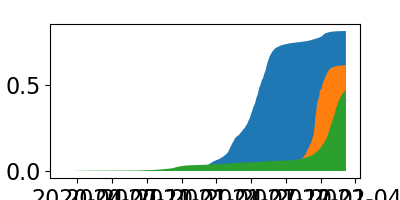

In [178]:
fig,ax1 = plt.subplots(figsize=(4,2))
ax1.fill_between(dfRatios.Date,dfRatios.Vacc)
ax1.fill_between(dfRatios.Date,dfRatios.Revacc)
ax1.fill_between(dfRatios.Date,dfRatios.Case)

(0.0, 1.0)

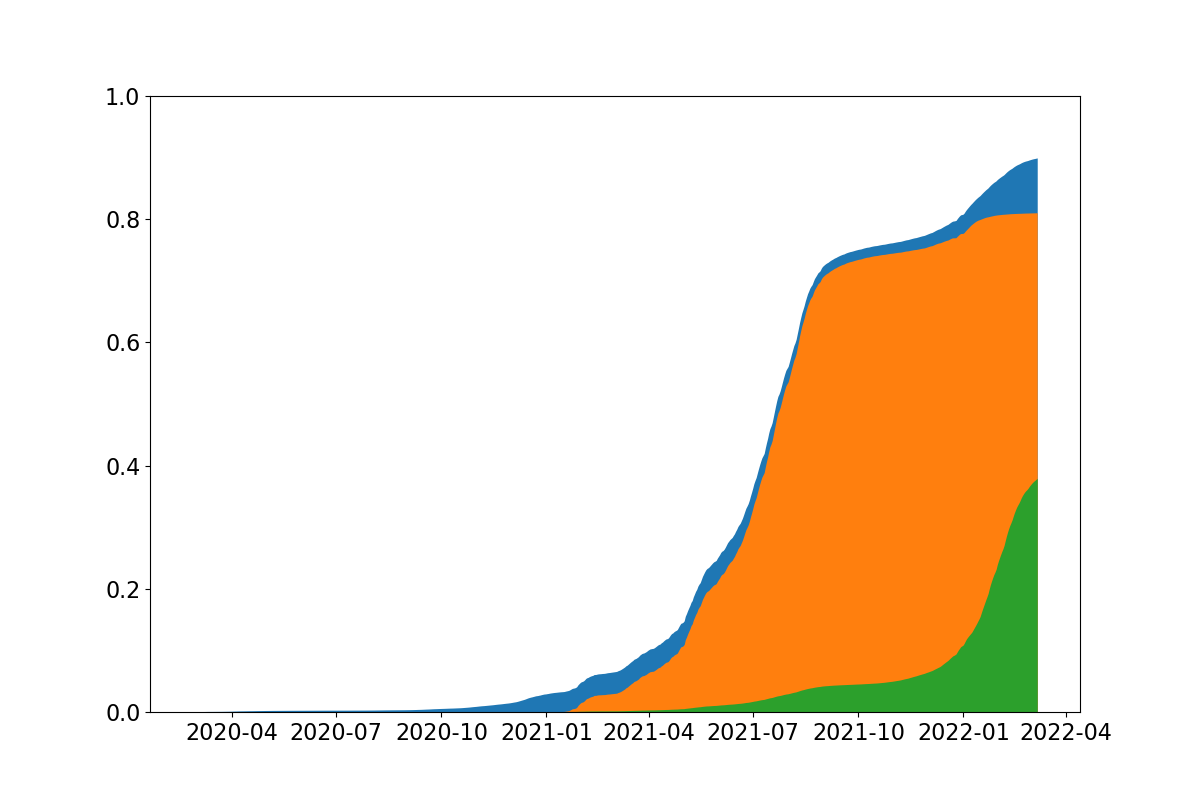

In [195]:
fig,ax1 = plt.subplots() 

inde = dfRatios.Case * dfRatios.Vacc

# ax1.fill_between(dfRatios.Date,dfRatios.Case + dfRatios.Vacc,label='Upper bound for immunity')
# ax1.fill_between(dfRatios.Date,dfRatios.Case + dfRatios.Vacc - inde,label='Assuming independence between infections and vaccination')
ax1.fill_between(dfRatios.Date,dfRatios.Vacc+dfRatios.Case-inde)
ax1.fill_between(dfRatios.Date,dfRatios.Vacc)
ax1.fill_between(dfRatios.Date,inde)
# ax1.fill_between(dfRatios.Date,dfRatios.Case)
# ax1.fill_between(dfRatios.Date,dfRatios.Vacc)
# ax1.fill_between(dfRatios.Date,dfRatios.Revacc)

ax1.set_ylim([0,1])

In [102]:
dfVacc.tail()
dfRevacc.tail()

,Count,Cumulative,Ratio
Date,,,
2022-03-03,1289,3596036,0.611646
2022-03-04,1203,3597239,0.611851
2022-03-05,838,3598077,0.611993
2022-03-06,879,3598956,0.612143
2022-03-07,1223,3600179,0.612351


In [54]:

# fig,ax1 = plt.subplots(figsize=(15,10)) 

# bgColor = 'xkcd:off white'
# fig.patch.set_facecolor(bgColor)
# ax1.set_facecolor(bgColor)

# rnDates = pf.rnTime(curDates,21)
# rnCases = pf.rnMean(curCases,21)
# rnDeaths = pf.rnMean(curDeaths,21)
# cfr = rnDeaths[21:]/rnCases[:-21]

# ax1.plot(rnDates[21:],100*cfr,'xkcd:dark red')

# ax1.set_yscale('log')

# ax1.set_ylim(top=2)
# ax1.set_ylim(bottom=0.05)

    
# def fmt(x, pos):
#     return f'{x:1.2f}'
# import matplotlib.ticker as ticker 
# ax1.yaxis.set_major_formatter(ticker.FuncFormatter(fmt))
# # ax1.yaxis.set_minor_formatter(ticker.FuncFormatter(fmt))
# ax1.tick_params(which='minor', labelsize=8) 


# ax1.set_yticks([0.05,0.1,0.2,0.5,1,2])
# ax1.grid(axis='y')

# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# # ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# ax1.set_title('COVID-19 case-fatality rate, Denmark')
# ax1.set_ylabel('Case-fatality rate in percent [%], logarithmic scale')

# smalltxt = 'Case-fatality rate estimated naively as number of registered deaths divided by number of cases three weeks prior.\nThree-week running means used for smoothing. PandemiX Center, Roskilde University. Based on publicly available data from Statens Serums Institut.'
# # smalltxt = 'Rasmus Kristoffer Pedersen, PandemiX Center, Roskilde Universitet.\nData fra SSI overvågningsdata, dashboard-fil. Filnavn: Regionalt_DB/18_fnkt_alder_uge_testede_positive_nyindlagte.csv'
# ax1.text(1,-0.15,smalltxt,
#      horizontalalignment='right',
#      verticalalignment='top',
#      transform = ax1.transAxes,
#      fontsize=10)
     
# ax1.spines['right'].set_visible(False)
# ax1.spines['top'].set_visible(False)

# xTicks = np.arange(np.datetime64('2020-04'),np.datetime64('2022-09'),np.timedelta64(3,'M'))
# ax1.set_xticks(xTicks)


# ax1.set_xlim(left=np.datetime64('2020-06'))
# ax1.set_xlim(right=np.datetime64('today'))
# ax1.set_xlim(right=np.datetime64('2022-04'))

# fig.tight_layout()

# if saveFigures:
#     fig.savefig(path_figs+'CaseFatality_NoLabels')

# def getValOnDay(date):
#     curIndex = rnDates[21:] == date 
#     return 100*cfr[curIndex]

# # ax1.text(np.datetime64('2020-06-15'),0.22,'(Uncertain period due to low testing)',
# #         size=10
# #         )
# # ax1.text(np.datetime64('2021-01-15'),1.5,'Upwards 1.3% of cases in\nwinter-wave of original strain',
# #         size=10,ha='center'
# #         )
# ax1.text(np.datetime64('2021-01-15'),1.5,'Winter-wave of original strain\nUpwards 13 deaths per 1,000 cases',
#         size=10,ha='center'
#         )
# ax1.text(np.datetime64('2021-05-01'),0.4,'Vaccinations, lockdown,\n& intense testing',
#         size=10,ha='center'
#         )

# thisDate = np.datetime64('2021-07-15')
# ax1.text(thisDate,.18,'Delta dominates',
#         size=10,ha='center'
#         )
# thisY = getValOnDay(thisDate+np.timedelta64(3,'D'))
# ax1.plot([thisDate,thisDate],[0.175,thisY],'k:',linewidth=2)

# ax1.text(np.datetime64('2021-10-01'),.6,'Delta-variant wave',
#         size=10,ha='center'
#         )
# ax1.text(np.datetime64('2021-11-15'),.45,'Booster rollout',
#         size=10,ha='left'
#         )

# thisDate = np.datetime64('2021-12-15')
# ax1.text(thisDate,.31,'Omikron dominates',
#         size=10,ha='left'
#         )
# thisY = getValOnDay(thisDate)
# ax1.plot([thisDate,thisDate],[0.3,thisY],'k:',linewidth=2)

# thisDate = np.datetime64('2022-02-01')
# ax1.text(thisDate,.12,'All restrictions lifted',
#         size=10,ha='left'
#         )
# thisY = getValOnDay(thisDate)
# ax1.plot([thisDate,thisDate],[0.11,thisY],'k:',linewidth=2)

# thisDate = np.datetime64('2022-02-27')
# ax1.text(thisDate,0.06,'Current status:\nLess than 1 death per 1,000 cases',
#         size=10,ha='center'
#         )
# # thisY = getValOnDay(thisDate)
# thisY = 100*cfr[-1]
# ax1.plot([thisDate,thisDate],[0.07,thisY],'k:',linewidth=2)

# fig.tight_layout()


# if saveFigures:
#     fig.savefig(path_figs+'CaseFatality')

In [38]:


# # ax1.text(np.datetime64('2020-06-15'),0.22,'(Uncertain period due to low testing)',
# #         size=10
# #         )
# ax1.text(np.datetime64('2021-01-15'),1.5,'Upwards 1.3% of cases in\nwinter-wave of original strain',
#         size=10,ha='center'
#         )
# ax1.text(np.datetime64('2021-05-15'),0.3,'Vaccinations, lockdown,\n& intense testing programme',
#         size=10,ha='center',rotation=-55
#         )
# ax1.text(np.datetime64('2021-10-01'),.5,'Rising Delta-variant wave',
#         size=10,ha='center',rotation=20
#         )
# ax1.text(np.datetime64('2022-01-01'),.2,'Arrival of Omikron and boosters',
#         size=10,ha='center',rotation=-55
#         )


In [39]:



# rnDates = pf.rnTime(curDates,7)
# rnCases = pf.rnMean(curCases,7)
# rnDeaths = pf.rnMean(curDeaths,7)
# cfr = rnDeaths[21:]/rnCases[:-21]
# ax1.plot(rnDates[21:],cfr)
# ax1.plot(pf.rnTime(rnDates[21:],28),pf.rnMean(cfr,28))



# Old below

In [40]:
# # Load data from "noegletal"
# # Until 2021-12-20, all dates were included in one file. Since then, additional data was added, and the file only contains the most recent numbers

# latestsubdirs_dash = list(os.walk(path_dash))[0][1]
# # latestsubdirs_dash == 'SSI_dashboard_2021-12-17'
# lastFullFileIndex = np.where([x == 'SSI_dashboard_2021-12-17' for x in latestsubdirs_dash])[0][0]
# latestdir_dash = path_dash + latestsubdirs_dash[lastFullFileIndex]

# dfKey = pd.read_csv(latestdir_dash+'\\Kommunalt_DB\\01_noegletal.csv',encoding='latin1',delimiter=';')

# dfKeysArray = []
# for k in range(lastFullFileIndex+1,len(latestsubdirs_dash)):
    
#     latestdir_dash = path_dash + latestsubdirs_dash[k]
#     curdf = pd.read_csv(latestdir_dash+'\\Kommunalt_DB\\01_noegletal.csv',encoding='latin1',delimiter=';')
#     dfKeysArray.append(curdf)
    

# dfKey['IndberetningDato'] = pd.to_datetime(dfKey['IndberetningDato'])

# # print(dfKey.columns)
# # dfKey.tail()

In [41]:
# # Make arrays to plot
# keyDates = dfKey.IndberetningDato
# keyDatesShift = keyDates + np.timedelta64(365,'D')
# keyCase = dfKey['Antal nye bekræftede tilfælde']
# keyNewAdm = dfKey['Antal nye indlæggelser']
# keyAdm = dfKey['Antal indlagte i dag med COVID']
# keyAdmInt = dfKey['Antal indlagt i dag på intensiv']
# keyAdmResp = dfKey['Antal indlagt i dag og i respirator']
# keyDeath = dfKey['Antal nye døde']
# keyTest = dfKey['Antal prøver siden sidst']

# ## Add the new data

# # 2021-12-20 still used old names
# dateToAdd = np.datetime64(pd.to_datetime(dfKeysArray[0].IndberetningDato.values[0]))
# keyDates = np.append(keyDates,dateToAdd)
# keyCase = np.append(keyCase,dfKeysArray[0]['Antal nye bekræftede tilfælde'][0])
# keyNewAdm = np.append(keyNewAdm,dfKeysArray[0]['Antal nye indlæggelser'][0])
# keyAdm = np.append(keyAdm,dfKeysArray[0]['Antal indlagte i dag med COVID'][0])
# keyAdmInt = np.append(keyAdmInt,dfKeysArray[0]['Antal indlagt i dag på intensiv'][0])
# keyAdmResp = np.append(keyAdmResp,dfKeysArray[0]['Antal indlagt i dag og i respirator'][0])
# keyDeath = np.append(keyDeath,dfKeysArray[0]['Antal nye døde'][0])
# keyTest = np.append(keyTest,dfKeysArray[0]['Antal prøver siden sidst'][0])

# # Make an array for missing reinfection data
# keyCaseReInf = keyCase * np.nan 

# # After which the new names are used
# for k in range(1,len(dfKeysArray)):
#     thisDate = dfKeysArray[k].Dato[0]
#     # thisCase = dfKeysArray[k]['Bekræftede tilfælde siden sidste opdatering'][0]
#     thisCase = dfKeysArray[k]['Bekræftede tilfælde i alt siden sidste opdatering'][0]
#     thisNewAdm = dfKeysArray[k]['Nyindlæggelser siden sidste opdatering'][0]
#     thisDeath = dfKeysArray[k]['Dødsfald siden sidste opdatering'][0]
#     thisAdm = dfKeysArray[k]['Indlæggelser i dag'][0]
#     thisAdmInt = dfKeysArray[k]['Indlæggelser i dag (intensiv)'][0]
#     thisAdmResp = dfKeysArray[k]['Indlæggelser i dag (respirator)'][0]
#     thisTest = dfKeysArray[k]['PRC-tests siden sidste opdatering'][0]
#     # # print(dfKeysArray[k])
#     # print(thisDate)
#     # print(thisAdm)
#     # print(thisAdmInt)
    
#     thisCaseReInf = dfKeysArray[k]['Reinfektioner siden sidste opdatering'][0]

#     keyDates = np.append(keyDates,np.datetime64(thisDate))
#     keyCase = np.append(keyCase,thisCase)
#     keyNewAdm = np.append(keyNewAdm,thisNewAdm)
#     keyAdm = np.append(keyAdm,thisAdm)
#     keyAdmInt = np.append(keyAdmInt,thisAdmInt)
#     keyAdmResp = np.append(keyAdmResp,thisAdmResp)
#     keyDeath = np.append(keyDeath,thisDeath)
#     keyTest = np.append(keyTest,thisTest)

#     keyCaseReInf = np.append(keyCaseReInf,thisCaseReInf)


# keyDates = keyDates.astype('datetime64[D]')
# keyDatesShift = keyDates + np.timedelta64(365,'D')

# # Collect everything in a single dataframe
# dfKeyFull = pd.DataFrame()
# dfKeyFull['Date'] = keyDates
# dfKeyFull['Cases_New'] = keyCase
# dfKeyFull['Cases_Reinfection'] = keyCaseReInf
# dfKeyFull['New_Admissions'] = keyNewAdm
# dfKeyFull['Hospitalizations'] = keyAdm
# dfKeyFull['ICU'] = keyAdmInt
# dfKeyFull['Respirator'] = keyAdmResp
# dfKeyFull['Deaths'] = keyDeath
# dfKeyFull['Tests'] = keyTest

In [42]:
# fig,ax1 = plt.subplots()

# ax1.plot(dfKeyFull.Date,dfKeyFull.Cases_New,label='New infections, noegletal-file')
# ax1.plot(dfKeyFull.Date,dfKeyFull.Cases_Reinfection,label='Reinfections, noegletal-file')
# # ax1.plot(dfKeyFull.Date,dfKeyFull.Cases_Reinfection+dfKeyFull.Cases_New)
# ax1.plot(df_reinf.index,df_reinf.infected,label='Reinfection, regional-sum')
# ax1.plot(df_reinf.index,df_inf.infected,':',label='New infections, regional-sum')

# # Draw weekends
# firstSunday = np.datetime64('2021-10-03')
# numWeeks = 30
# for k in range(-numWeeks,numWeeks):
#      curSunday = firstSunday + np.timedelta64(7*k,'D')
#      ax1.axvspan(curSunday-np.timedelta64(1,'D')-np.timedelta64(12,'h'),curSunday+np.timedelta64(12,'h'),zorder=-1,facecolor='lightgrey',label=int(k==0)*'Weekend')
# ax1.grid(axis='y')
# ax1.legend(loc='upper left')

# ax1.set_xlim(left=np.datetime64('2021-10-01'))
# ax1.set_ylim(bottom=0)

In [43]:
# keyCaseReInf[np.isnan(keyCaseReInf)] = 0
# totCase = keyCase + keyCaseReInf

In [44]:
# wave1Start = np.datetime64('2020-10-01') 
# wave1End = np.datetime64('2021-03-01') 
# caseWave1 = totCase[(keyDates >= wave1Start- np.timedelta64(4,'D')) & (keyDates <= wave1End+ np.timedelta64(4,'D'))]
# deathWave1 = keyDeath[(keyDates >= wave1Start- np.timedelta64(4,'D')) & (keyDates <= wave1End+ np.timedelta64(4,'D'))]
# daysWave1 = keyDates[(keyDates >= wave1Start- np.timedelta64(4,'D')) & (keyDates <= wave1End+ np.timedelta64(4,'D'))]

# wave2Start = np.datetime64('2021-11-01') 
# wave2End = np.datetime64('2022-04-01')
# caseWave2 = totCase[(keyDates >= wave2Start- np.timedelta64(4,'D')) & (keyDates <= wave2End + np.timedelta64(4,'D'))]
# deathWave2 = keyDeath[(keyDates >= wave2Start- np.timedelta64(4,'D')) & (keyDates <= wave2End + np.timedelta64(4,'D'))]
# daysWave2 = keyDates[(keyDates >= wave2Start- np.timedelta64(4,'D')) & (keyDates <= wave2End + np.timedelta64(4,'D'))]

In [45]:
# # wave1TopIndex = np.argmax(caseWave1)

# # wave1TopDate = daysWave1[wave1TopIndex]
# # wave1TopCase = caseWave1[wave1TopIndex]

# wave1TopIndex = np.argmax(pf.rnMean(caseWave1))

# wave1TopDate = pf.rnTime(daysWave1)[wave1TopIndex]
# wave1TopCase = pf.rnMean(caseWave1)[wave1TopIndex]

# wave2TopIndex = np.argmax(pf.rnMean(caseWave2))

# wave2TopDate = pf.rnTime(daysWave2)[wave2TopIndex]
# wave2TopCase = pf.rnMean(caseWave2)[wave2TopIndex]

# # fig,ax1 = plt.subplots()
# # # ax1.text(4,2,'asdf ')
# # ax1.plot(wave1TopDate,wave1TopCase/DKpop,'*')
# # ax1.text(wave1TopDate,wave1TopCase/DKpop, "eggs", size=50, rotation=30.,
# #          ha="center", va="center",
# #          bbox=dict(boxstyle="round",
# #                    ec=(1., 0.5, 0.5),
# #                    fc=(1., 0.8, 0.8),
# #                    )
# #          )

# # ax1.text(wave1TopDate,wave1TopCase/DKpop,'ASDF')


In [46]:
# fig,(ax1,ax2) = plt.subplots(2,1) 

# DKpop = 5860590 # According to data in reinfection file

# ax1_2 = ax1.twinx()
# ax2_2 = ax2.twinx() 

# # ax1.plot(keyDates,1000*keyCase/DKpop)
# # ax1_2.plot(keyDates,1000*keyDeath/DKpop,'r')

# # ax1.plot(daysWave1,1000*caseWave1/DKpop)
# # ax1_2.plot(daysWave1,1000000*deathWave1/DKpop,'r')
# ax1.plot(pf.rnTime(daysWave1),pf.rnMean(1000*caseWave1/DKpop),'b')
# ax1_2.plot(pf.rnTime(daysWave1),pf.rnMean(1000000*deathWave1/DKpop),'r')

# # ax2.plot(daysWave2,1000*caseWave2/DKpop)
# # ax2_2.plot(daysWave2,1000000*deathWave2/DKpop,'r')
# ax2.plot(pf.rnTime(daysWave2),pf.rnMean(1000*caseWave2/DKpop),'b')
# ax2_2.plot(pf.rnTime(daysWave2),pf.rnMean(1000000*deathWave2/DKpop),'r')




# ax1.set_ylim(bottom=0)
# ax1_2.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
# ax2_2.set_ylim(bottom=0)

# ax1_2.set_ylim(top=9)
# ax2_2.set_ylim(top=9)

# ax1.set_ylim(top=9)
# ax2.set_ylim(top=9)

# ax1.set_xlim([wave1Start,wave1End])
# ax1_2.set_xlim([wave1Start,wave1End])

# ax2.set_xlim([wave2Start,wave2End])
# ax2_2.set_xlim([wave2Start,wave2End])

# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# ax1.set_ylabel('Daily cases\nper 1,000 citizens')
# ax2.set_ylabel('Daily cases\nper 1,000 citizens')
# ax1_2.set_ylabel('Daily deaths\nper 1,000,000 citizens')
# ax2_2.set_ylabel('Daily deaths\nper 1,000,000 citizens')
# # ax1.set_ylabel('Daily cases\nper 1,000 citizens\n[7 day mean]')
# # ax2.set_ylabel('Daily cases\nper 1,000 citizens\n[7 day mean]')
# # ax1_2.set_ylabel('Daily deaths\nper 1,000,000 citizens\n[7 day mean]')
# # ax2_2.set_ylabel('Daily deaths\nper 1,000,000 citizens\n[7 day mean]')
# # ax2.set_ylabel('Cases per 1,000 citizens')
# # ax2_2.set_ylabel('Deaths per 1,000,000 citizens')



# # ax1.spines['right'].set_visible=('b')

# ax1.yaxis.label.set_color('b')
# ax2.yaxis.label.set_color('b')

# ax1.spines['left'].set_edgecolor('b')
# ax2.spines['left'].set_edgecolor('b')

# ax1_2.yaxis.label.set_color('r')
# ax2_2.yaxis.label.set_color('r')

# ax1_2.spines['right'].set_edgecolor('r')
# ax2_2.spines['right'].set_edgecolor('r')

# ax1_2.spines['left'].set_visible(False)
# ax2_2.spines['left'].set_visible(False)


# ax1.spines['top'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax1_2.spines['top'].set_visible(False)
# ax2_2.spines['top'].set_visible(False)

# ax1.tick_params(axis='y', colors='b')
# ax2.tick_params(axis='y', colors='b')
# ax1_2.tick_params(axis='y', colors='r')
# ax2_2.tick_params(axis='y', colors='r')

# ax1.grid(axis='y',color='gray')
# ax2.grid(axis='y',color='gray')



# fig.tight_layout()

# if saveFigures:
#         fig.savefig(path_figs + 'WinterWavesCaseAndDeaths')



# wave1Max = 1000*wave1TopCase/DKpop
# ax1.text(wave1TopDate+np.timedelta64(7,'D'),wave1Max*1.4,f'Max: {wave1Max:0.2f} cases per 1,000',
#         size=9,
#         ha="left", va="bottom",
#         bbox=dict(boxstyle="round",
#                    ec=(0., 0,0),
#                    fc=(0.8, 0.8, 1),
#                    ))

# if saveFigures:
#         fig.savefig(path_figs + 'WinterWavesCaseAndDeaths_WithLabelsOnlyOne')

# wave2Max = 1000*wave2TopCase/DKpop
# ax2.text(wave2TopDate-np.timedelta64(14,'D'),wave2Max,f'Max: {wave2Max:0.2f} cases per 1,000',
#         size=9,
#         ha="right", va="bottom",
#         bbox=dict(boxstyle="round",
#                    ec=(0., 0,0),
#                    fc=(0.8, 0.8, 1),
#                    ))

                   
# if saveFigures:
#         fig.savefig(path_figs + 'WinterWavesCaseAndDeaths_WithLabels')